In [1]:
import numpy as np
import pandas as pd
import polars as pl

import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
chicago_taxi_dataset = pl.DataFrame(pd.read_csv("https://download.mlcc.google.com/mledu-datasets/chicago_taxi_train.csv"))

In [3]:
training_df = chicago_taxi_dataset.with_columns(
    pl.col("TRIP_START_TIMESTAMP").str.strptime(pl.Datetime, "%m/%d/%Y %I:%M:%S %p").alias("TRIP_START_TIMESTAMP"),
    pl.col("TRIP_END_TIMESTAMP").str.strptime(pl.Datetime, "%m/%d/%Y %I:%M:%S %p").alias("TRIP_END_TIMESTAMP"),
).select('TRIP_MILES', 'TRIP_SECONDS', 'FARE', 'COMPANY', 'PAYMENT_TYPE', 'TIP_RATE')

In [4]:
corr_matrix = training_df.select("FARE", "TRIP_SECONDS", "TRIP_MILES", "TIP_RATE").corr()
corr_matrix

FARE,TRIP_SECONDS,TRIP_MILES,TIP_RATE
f64,f64,f64,f64
1.0,0.830292,0.975344,-0.070979
0.830292,1.0,0.800855,-0.084294
0.975344,0.800855,1.0,-0.049594
-0.070979,-0.084294,-0.049594,1.0


# Model Comparison: With and Without Regularization

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [6]:
# Prepare the feature matrix and target variable
X_full = (
    training_df
    .with_columns((pl.col("TRIP_SECONDS")/60).alias("TRIP_MINUTES"))
    .drop("FARE", "TRIP_SECONDS")
    .to_dummies(columns=["COMPANY", "PAYMENT_TYPE"], drop_first=True)
    .to_pandas()
)

y_full = training_df["FARE"].to_numpy()

# Split data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print(f"Training set size: {len(X_train)} samples ({len(X_train)/len(X_full)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} samples ({len(X_val)/len(X_full)*100:.1f}%)")
print(f"Test set size: {len(X_test)} samples ({len(X_test)/len(X_full)*100:.1f}%)")
print(f"Total samples: {len(X_full)}")

Training set size: 19016 samples (60.0%)
Validation set size: 6339 samples (20.0%)
Test set size: 6339 samples (20.0%)
Total samples: 31694


## Linear Regression (No Regularization)

In [7]:
# Train linear regression without regularization
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions on all three sets
y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)
y_test_pred_lr = lr_model.predict(X_test)

# Calculate metrics
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
val_rmse_lr = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))

train_r2_lr = r2_score(y_train, y_train_pred_lr)
val_r2_lr = r2_score(y_val, y_val_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print("Linear Regression (No Regularization) Results:")
print("="*50)
print(f"Training   - RMSE: ${train_rmse_lr:.4f}, R²: {train_r2_lr:.4f}")
print(f"Validation - RMSE: ${val_rmse_lr:.4f}, R²: {val_r2_lr:.4f}")
print(f"Test       - RMSE: ${test_rmse_lr:.4f}, R²: {test_r2_lr:.4f}")
print(f"\nOverfitting check (Val RMSE - Train RMSE): ${val_rmse_lr - train_rmse_lr:.4f}")

Linear Regression (No Regularization) Results:
Training   - RMSE: $3.3981, R²: 0.9593
Validation - RMSE: $3.3725, R²: 0.9613
Test       - RMSE: $3.5495, R²: 0.9574

Overfitting check (Val RMSE - Train RMSE): $-0.0256


## Ridge Regression (L2 Regularization)

In [8]:
# Test different alpha values on validation set to find the best regularization strength
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
val_rmses = []

for alpha in alphas:
    ridge_temp = Ridge(alpha=alpha)
    ridge_temp.fit(X_train, y_train)
    y_val_pred_temp = ridge_temp.predict(X_val)
    val_rmse_temp = np.sqrt(mean_squared_error(y_val, y_val_pred_temp))
    val_rmses.append(val_rmse_temp)
    print(f"Alpha: {alpha:7.3f} -> Validation RMSE: ${val_rmse_temp:.4f}")

best_alpha = alphas[np.argmin(val_rmses)]
print(f"\nBest alpha: {best_alpha}")

Alpha:   0.001 -> Validation RMSE: $3.3725
Alpha:   0.010 -> Validation RMSE: $3.3725
Alpha:   0.100 -> Validation RMSE: $3.3725
Alpha:   1.000 -> Validation RMSE: $3.3725
Alpha:  10.000 -> Validation RMSE: $3.3729
Alpha: 100.000 -> Validation RMSE: $3.3772
Alpha: 1000.000 -> Validation RMSE: $3.3909

Best alpha: 1


In [9]:
# Train Ridge regression with best alpha
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

# Predictions on all three sets
y_train_pred_ridge = ridge_model.predict(X_train)
y_val_pred_ridge = ridge_model.predict(X_val)
y_test_pred_ridge = ridge_model.predict(X_test)

# Calculate metrics
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
val_rmse_ridge = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
val_r2_ridge = r2_score(y_val, y_val_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

print(f"Ridge Regression (Alpha={best_alpha}) Results:")
print("="*50)
print(f"Training   - RMSE: ${train_rmse_ridge:.4f}, R²: {train_r2_ridge:.4f}")
print(f"Validation - RMSE: ${val_rmse_ridge:.4f}, R²: {val_r2_ridge:.4f}")
print(f"Test       - RMSE: ${test_rmse_ridge:.4f}, R²: {test_r2_ridge:.4f}")
print(f"\nOverfitting check (Val RMSE - Train RMSE): ${val_rmse_ridge - train_rmse_ridge:.4f}")

Ridge Regression (Alpha=1) Results:
Training   - RMSE: $3.3981, R²: 0.9593
Validation - RMSE: $3.3725, R²: 0.9613
Test       - RMSE: $3.5494, R²: 0.9574

Overfitting check (Val RMSE - Train RMSE): $-0.0257


## Model Comparison

In [10]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Train RMSE', 'Val RMSE', 'Test RMSE', 'Train R²', 'Val R²', 'Test R²', 'Overfitting Gap (Val-Train RMSE)'],
    'Linear Regression': [
        f'${train_rmse_lr:.4f}',
        f'${val_rmse_lr:.4f}',
        f'${test_rmse_lr:.4f}',
        f'{train_r2_lr:.4f}',
        f'{val_r2_lr:.4f}',
        f'{test_r2_lr:.4f}',
        f'${val_rmse_lr - train_rmse_lr:.4f}'
    ],
    'Ridge Regression': [
        f'${train_rmse_ridge:.4f}',
        f'${val_rmse_ridge:.4f}',
        f'${test_rmse_ridge:.4f}',
        f'{train_r2_ridge:.4f}',
        f'{val_r2_ridge:.4f}',
        f'{test_r2_ridge:.4f}',
        f'${val_rmse_ridge - train_rmse_ridge:.4f}'
    ]
})

print("\nModel Performance Comparison:")
print("="*70)
print(comparison_df.to_string(index=False))
print("\n" + "="*70)

# Calculate improvements
rmse_improvement = ((val_rmse_lr - val_rmse_ridge) / val_rmse_lr) * 100
gap_reduction = ((val_rmse_lr - train_rmse_lr) - (val_rmse_ridge - train_rmse_ridge))

print(f"\nValidation RMSE improvement with Ridge: {rmse_improvement:.2f}%")
print(f"Overfitting gap reduction with Ridge: ${gap_reduction:.4f}")


Model Performance Comparison:
                          Metric Linear Regression Ridge Regression
                      Train RMSE           $3.3981          $3.3981
                        Val RMSE           $3.3725          $3.3725
                       Test RMSE           $3.5495          $3.5494
                        Train R²            0.9593           0.9593
                          Val R²            0.9613           0.9613
                         Test R²            0.9574           0.9574
Overfitting Gap (Val-Train RMSE)          $-0.0256         $-0.0257


Validation RMSE improvement with Ridge: 0.00%
Overfitting gap reduction with Ridge: $0.0001


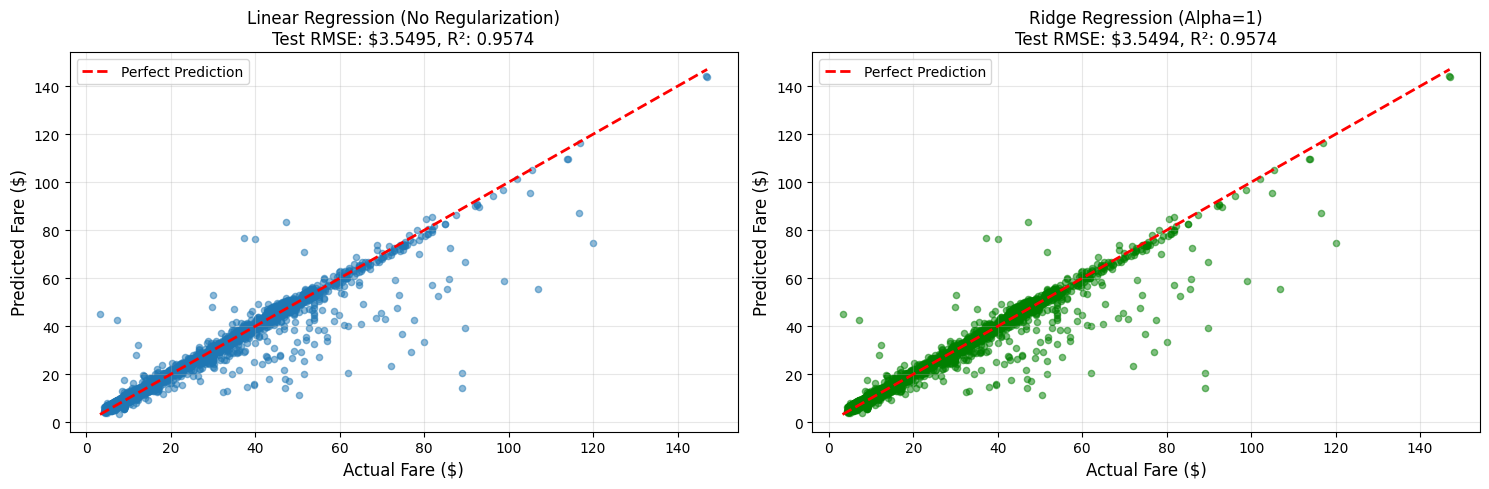

In [11]:
# Plot 1: Actual vs Predicted for both models (on test set)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Linear Regression
axes[0].scatter(y_test, y_test_pred_lr, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Fare ($)', fontsize=12)
axes[0].set_ylabel('Predicted Fare ($)', fontsize=12)
axes[0].set_title(f'Linear Regression (No Regularization)\nTest RMSE: ${test_rmse_lr:.4f}, R²: {test_r2_lr:.4f}', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Ridge Regression
axes[1].scatter(y_test, y_test_pred_ridge, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Fare ($)', fontsize=12)
axes[1].set_ylabel('Predicted Fare ($)', fontsize=12)
axes[1].set_title(f'Ridge Regression (Alpha={best_alpha})\nTest RMSE: ${test_rmse_ridge:.4f}, R²: {test_r2_ridge:.4f}', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
def predict_fare(trip_miles, trip_minutes, company, payment_type, use_ridge=True):
    new_data = pl.DataFrame({
        "TRIP_MILES": [trip_miles],
        "TRIP_MINUTES": [trip_minutes], 
        "COMPANY": [company],
        "PAYMENT_TYPE": [payment_type],
        "TIP_RATE": [0.0]  # Not used in prediction, but needed for dummy encoding
    })
    X_new = (new_data
             .drop("TIP_RATE")
             .to_dummies(columns=["COMPANY", "PAYMENT_TYPE"], drop_first=True)
             .to_pandas())
    X_new = X_new.reindex(columns=X_train.columns, fill_value=0)
    model = ridge_model if use_ridge else lr_model
    return model.predict(X_new)[0]

# Test prediction
predicted_fare = predict_fare(
    trip_miles=15.2, 
    trip_minutes=50.0,
    company="Yellow Cab", 
    payment_type="Credit Card"
)
print(f"Predicted fare: ${predicted_fare:.2f}")

Predicted fare: $43.27
